In [1]:
import numpy as np
import pandas as pd
import sys
from typing import Dict, List, Union, Tuple, Optional
from scipy import integrate
from numpy import linalg as LA
from math import pi
import logging

In [2]:
def validate_inputs(phi: Union[List[float], np.ndarray],
                   lambda_i: Union[List[float], np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
    """Validate and normalize inputs with strict checks"""
    phi = np.asarray(phi, dtype=np.float64).flatten()
    lambda_i = np.asarray(lambda_i, dtype=np.float64).flatten()

    if np.any(lambda_i <= 0):
        raise ValueError("All thermal conductivities must be positive")

    if len(phi) != len(lambda_i):
        raise ValueError(f"Length mismatch: phi ({len(phi)}) vs lambda_i ({len(lambda_i)})")

    total_phi = np.sum(phi)
    if not np.isclose(total_phi, 1.0, atol=1e-6):
        # Normalize only if sum is not 1
        phi = phi / total_phi
        print(f"Volume fractions not summing to 1 ({total_phi:.6f}), normalizing...")

    return phi, lambda_i

In [3]:
def Wiener_Upper_Bound(phi: List[float], lambda_i: List[float], alpha_i: Optional[List[float]] = None) -> float:
    """Wiener's upper bound (arithmetic mean)"""
    phi, lam = validate_inputs(phi, lambda_i)
    return np.sum(phi * lam)

def Wiener_Lower_Bound(phi: List[float], lambda_i: List[float], alpha_i: Optional[List[float]] = None) -> float:
    """Wiener's lower bound (harmonic mean)"""
    phi, lam = validate_inputs(phi, lambda_i)
    return 1.0 / np.sum(phi / (lam + 1e-10))

def Wiener_Average(phi: List[float], lambda_i: List[float], alpha_i: Optional[List[float]] = None) -> float:
    """Geometric mean of Wiener bounds"""
    upper = Wiener_Upper_Bound(phi, lambda_i)
    lower = Wiener_Lower_Bound(phi, lambda_i)
    return np.mean([upper, lower])

def Lichtenecker(phi: List[float], lambda_i: List[float], alpha_i: Optional[List[float]] = None) -> float:
    """Lichtenecker's logarithmic mixing rule"""
    phi, lam = validate_inputs(phi, lambda_i)
    return np.exp(np.sum(phi * np.log(lam + 1e-10)))

In [4]:
from typing import List, Optional
import numpy as np

def validate_inputs_HS(phi: List[float], lambda_i: List[float]) -> tuple[np.ndarray, np.ndarray]:
    """
    Validate and normalize inputs for volume fractions and thermal conductivities.

    Args:
        phi: List or array of volume fractions.
        lambda_i: List or array of thermal conductivities (W/m·K).

    Returns:
        Tuple of numpy arrays (phi, lambda_i) after validation.

    Raises:
        ValueError: If inputs are invalid (e.g., negative values, incorrect sum, or mismatched lengths).
    """
    phi = np.array(phi, dtype=float)
    lambda_i = np.array(lambda_i, dtype=float)

    if len(phi) != len(lambda_i):
        raise ValueError("Volume fractions and conductivities must have the same length")
    if len(phi) < 1:
        raise ValueError("At least one phase is required")
    if any(phi < 0):
        raise ValueError("Volume fractions must be non-negative")
    if any(lambda_i <= 0):
        raise ValueError("Thermal conductivities must be positive")
    if not np.isclose(np.sum(phi), 1.0, rtol=1e-6):
        raise ValueError("Volume fractions must sum to 1.0")

    return phi, lambda_i

def Lower_Hashin_Strikman(phi: List[float],
                          lambda_i: List[float],
                          alpha_i: Optional[List[float]] = None) -> float:
    """
    Lower Hashin-Shtrikman bound for effective thermal conductivity.
    Assumes spherical inclusions (depolarization factor f = 1/3).

    Args:
        phi: List or array of volume fractions.
        lambda_i: List or array of thermal conductivities (W/m·K).
        alpha_i: Optional list or array of shape factors (not used, included for compatibility).

    Returns:
        float: Lower bound effective thermal conductivity (W/m·K).

    Raises:
        ValueError: If inputs are invalid or calculations result in near-zero denominators.
    """
    phi, lam = validate_inputs_HS(phi, lambda_i)
    if len(lam) == 1:
        return float(lam[0])

    L0 = min(lam)  # Lowest conductivity as reference
    f = 1.0 / 3.0  # Spherical inclusions

    HS_comp1, HS_comp2 = [], []
    for v, k in zip(phi, lam):
        term_3 = v * k / (L0 * (1 - f) + k * f + 1e-10)  # Avoid division by zero
        term_12 = v * k / (L0 * (1 + f) / 2 + k * (1 - f) / 2 + 1e-10)
        HS_comp1.append((term_3 + 2 * term_12) / 3)
        HS_comp2.append(v / (L0 * (1 - f) + k * f + 1e-10))

    sum_comp2 = np.sum(HS_comp2)
    if abs(sum_comp2) < 1e-12:
        raise ValueError("Near-zero denominator in Lower HS bound calculation")

    return float(np.sum(HS_comp1) / sum_comp2)

def Upper_Hashin_Strikman(phi: List[float],
                          lambda_i: List[float],
                          alpha_i: Optional[List[float]] = None) -> float:
    """
    Upper Hashin-Shtrikman bound for effective thermal conductivity.
    Assumes spherical inclusions (depolarization factor f = 1/3).

    Args:
        phi: List or array of volume fractions.
        lambda_i: List or array of thermal conductivities (W/m·K).
        alpha_i: Optional list or array of shape factors (not used, included for compatibility).

    Returns:
        float: Upper bound effective thermal conductivity (W/m·K).

    Raises:
        ValueError: If inputs are invalid or calculations result in near-zero denominators.
    """
    phi, lam = validate_inputs_HS(phi, lambda_i)
    if len(lam) == 1:
        return float(lam[0])

    L0 = max(lam)  # Highest conductivity as reference
    f = 1.0 / 3.0  # Spherical inclusions

    HS_comp1, HS_comp2 = [], []
    for v, k in zip(phi, lam):
        term_3 = v * k / (L0 * (1 - f) + k * f + 1e-10)  # Avoid division by zero
        term_12 = v * k / (L0 * (1 + f) / 2 + k * (1 - f) / 2 + 1e-10)
        HS_comp1.append((term_3 + 2 * term_12) / 3)
        HS_comp2.append(v / (L0 * (1 - f) + k * f + 1e-10))

    sum_comp2 = np.sum(HS_comp2)
    if abs(sum_comp2) < 1e-12:
        raise ValueError("Near-zero denominator in Upper HS bound calculation")

    return float(np.sum(HS_comp1) / sum_comp2)

def Hashin_Strikman_Average(phi: List[float],
                            lambda_i: List[float],
                            alpha_i: Optional[List[float]] = None) -> float:
    """
    Geometric mean of Hashin-Shtrikman bounds with fallback handling.

    Args:
        phi: List or array of volume fractions.
        lambda_i: List or array of thermal conductivities (W/m·K).
        alpha_i: Optional list or array of shape factors (not used, included for compatibility).

    Returns:
        float: Effective thermal conductivity average (W/m·K).

    Raises:
        Exception: If calculations fail, falls back to arithmetic mean.
    """
    try:
        phi, lam = validate_inputs_HS(phi, lambda_i)
        if len(lam) == 1:
            return float(lam[0])

        upper = Upper_Hashin_Strikman(phi, lam, alpha_i)
        lower = Lower_Hashin_Strikman(phi, lam, alpha_i)

        if np.isnan(upper) or np.isnan(lower):
            return float(np.sum(phi * lam))  # Fallback to weighted arithmetic mean

        if upper <= 0 or lower <= 0:
            return float(np.sum(phi * lam))  # Fallback to weighted arithmetic mean

        if np.isclose(upper, lower, rtol=1e-6):
            return float(upper)

        geometric_mean = np.mean([upper, lower])
        if np.isnan(geometric_mean):
            return float(np.mean([upper, lower]))

        return float(geometric_mean)

    except Exception as e:
        print(f"Hashin-Shtrikman average calculation failed: {e}. Falling back to arithmetic mean.")
        return float(np.sum(phi * lambda_i))

In [5]:
import numpy as np
from scipy.optimize import root_scalar

def validate_inputs_Bruggeman(volume_fractions, thermal_conductivities):
    """Validate and prepare inputs for Bruggeman calculation with enhanced checks"""
    phi = np.asarray(volume_fractions, dtype=float)
    lam = np.asarray(thermal_conductivities, dtype=float)

    # Check for positive values
    if np.any(phi < 0):
        raise ValueError("Volume fractions must be ≥ 0")
    if np.any(lam <= 0):
        raise ValueError("Thermal conductivities must be > 0")

    # Remove components with zero volume
    mask = phi > 1e-10  # Consider values below 1e-10 as zero
    phi = phi[mask]
    lam = lam[mask]

    # Normalize volume fractions
    phi_sum = np.sum(phi)
    if phi_sum < 1e-10:
        raise ValueError("Sum of volume fractions is effectively zero")
    phi = phi / phi_sum

    return phi, lam

def Bruggeman_EMA(phi, lambda_i, alpha_i=None, tol=1e-8, max_iter=100):
    """
    Calculate effective thermal conductivity using Bruggeman's EMA.

    Parameters:
        phi (array-like): Volume fractions (must sum to 1 ± 1e-6)
        lambda_i (array-like): Component thermal conductivities (must be > 0)
        alpha_i (array-like, optional): Aspect ratios (unused in Bruggeman)
        tol (float): Convergence tolerance
        max_iter (int): Maximum iterations

    Returns:
        float: Effective thermal conductivity
    """
    # Rename parameters to match internal names
    volume_fractions = phi
    thermal_conductivities = lambda_i

    # Validate inputs
    phi, lam = validate_inputs_Bruggeman(volume_fractions, thermal_conductivities)

    # Handle single component case
    if len(phi) == 1:
        return float(lam[0])

    # Binary mixture analytical solution
    if len(phi) == 2:
        phi1, phi2 = phi
        lambda1, lambda2 = lam
        if phi2 < 1e-10:
            return float(lambda1)
        if phi1 < 1e-10:
            return float(lambda2)

        B = (3*phi2 - 1)*lambda2 + (3*phi1 - 1)*lambda1
        discriminant = B**2 + 8*lambda1*lambda2
        if discriminant >= 0:
            return float((B + np.sqrt(discriminant))) / 4

    # General N-component case
    def bruggeman_eq(leff):
        with np.errstate(divide='ignore', invalid='ignore'):
            terms = phi * (lam - leff) / (lam + 2*leff)
        terms = np.nan_to_num(terms, nan=0.0, posinf=0.0, neginf=0.0)
        return np.sum(terms)

    # Find reasonable bounds
    lower = max(1e-10, 0.1 * min(lam))
    upper = min(1e10, 10.0 * max(lam))

    # Try multiple solving methods
    methods = ['brentq', 'bisect', 'ridder']
    for method in methods:
        try:
            sol = root_scalar(bruggeman_eq, bracket=[lower, upper],
                             method=method, xtol=tol, maxiter=max_iter)
            if sol.converged:
                return float(sol.root)
        except (ValueError, RuntimeError):
            continue

    # Fallback to geometric mean
    return float(np.exp(np.sum(phi * np.log(lam))))

In [6]:
# === MAXWELL-GARNETT N-COMPONENT MODEL ===
import numpy as np

def validate_inputs_Maxwell_Garnett(phi, lambda_i):
    """
    Validate inputs for Maxwell-Garnett model.
    Ensures volume fractions sum to 1 and converts inputs to NumPy arrays.
    """
    phi = np.array(phi, dtype=float)
    lambda_i = np.array(lambda_i, dtype=float)

    if len(phi) != len(lambda_i):
        raise ValueError("Volume fractions and thermal conductivities must have the same length.")
    if not np.isclose(np.sum(phi), 1.0, rtol=1e-5):
        raise ValueError("Volume fractions must sum to 1.")
    if np.any(phi < 0) or np.any(lambda_i <= 0):
        raise ValueError("Volume fractions and thermal conductivities must be non-negative.")

    return phi, lambda_i

def Maxwell_Garnett_NComponent(volume_fractions, thermal_conductivities, matrix_index=0,
                              depolarization_factors=None):
    """
    Generalized Maxwell-Garnett effective medium theory for N-component composites.
    Handles ellipsoidal inclusions via depolarization factors.
    Returns scalar (isotropic) or tuple (anisotropic).
    """
    phi = np.array(volume_fractions)
    lam = np.array(thermal_conductivities)
    lam0 = lam[matrix_index]

    # Handle depolarization factors
    if depolarization_factors is None:
        L = np.array([(1/3, 1/3, 1/3)] * (len(phi)-1))  # spherical
    elif isinstance(depolarization_factors, tuple):
        L = np.array([depolarization_factors] * (len(phi)-1))
    else:
        L = np.array(depolarization_factors)

    # Remove matrix from inclusions
    phi_incl = np.delete(phi, matrix_index)
    lam_incl = np.delete(lam, matrix_index)

    lambda_eff = []
    for axis in range(3):
        L_axis = L[:, axis]
        beta = (lam_incl - lam0) / (lam_incl + L_axis * lam0 + 1e-10)
        sum_phi_beta = np.sum(phi_incl * beta)
        lambda_axis = lam0 * (1 + sum_phi_beta / (1 - sum_phi_beta + 1e-10))
        lambda_eff.append(lambda_axis)

    # Return isotropic average if symmetric, else full anisotropy
    if np.allclose(L[:,0], L[:,1]) and np.allclose(L[:,0], L[:,2]):
        return lambda_eff[0]
    else:
        return tuple(lambda_eff)


# === MAXWELL WRAPPER: Enforces Spherical Inclusions ===
def Maxwell(phi, lambda_i, alpha_i=None):
    """
    N-component Maxwell-Garnett model with enforced spherical inclusions (AR = 1).
    Ignores input ARs and uses depolarization factor L = 1/3 per axis.
    Matrix is assumed to be index 0.
    """
    # Force spherical assumption: override all ARs → L = (1/3, 1/3, 1/3)
    phi, lambda_i = validate_inputs_Maxwell_Garnett(phi, lambda_i)
    depolarization_factors = None  # triggers default 1/3

    result = Maxwell_Garnett_NComponent(
        volume_fractions=phi,
        thermal_conductivities=lambda_i,
        matrix_index=0,
        depolarization_factors=depolarization_factors
    )

    # Return scalar (isotropic)
    return float(result) if isinstance(result, (float, int)) else float(np.mean(result))

In [14]:
import numpy as np
from typing import List, Union, Tuple, Optional
from scipy import integrate
from numpy import linalg as LA
from math import pi

class GSAModel:
    """
    Generalized Self-Consistent Approach (GSA) model for calculating effective thermal conductivity
    of composite materials with ellipsoidal inclusions (both isotropic and anisotropic).
    """

    def __init__(self,
                 phi: Union[List[float], np.ndarray],
                 lambda_i: Union[List[float], List[np.ndarray]],
                 alpha_shape: Union[List[float], List[List[float]]],
                 max_iter: int = 1000,
                 tol: float = 1e-6,
                 method: str = 'self-consistent',
                 f_param: Optional[Union[List[float], np.ndarray]] = None,
                 isotropic: bool = True):

        self.phi = np.asarray(phi)
        self.lambda_i = [np.asarray(lam) if isinstance(lam, (list, np.ndarray)) else lam
                        for lam in lambda_i]
        self.alpha_shape = [np.asarray(alpha) if isinstance(alpha, (list, np.ndarray)) else alpha
                           for alpha in alpha_shape]
        self.max_iter = max_iter
        self.tol = tol
        self.method = method.lower()
        self.f_param = np.asarray(f_param) if f_param is not None else None
        self.isotropic = isotropic

        self._validate_inputs()
        self._process_inputs()

    def _validate_inputs(self) -> None:
        """Validate input parameters."""
        if not np.isclose(np.sum(self.phi), 1.0, atol=1e-4):
            raise ValueError("Volume fractions must sum to 1")

        if len(self.phi) != len(self.lambda_i) or len(self.phi) != len(self.alpha_shape):
            raise ValueError("phi, lambda_i, and alpha_shape must have same length")

        if any(self.phi < 0) or any(self.phi > 1):
            raise ValueError("Volume fractions must be between 0 and 1")

        if self.method not in ['self-consistent', 'f-model']:
            raise ValueError("Method must be 'self-consistent' or 'f-model'")

        if self.method == 'f-model' and self.f_param is None:
            raise ValueError("f_param must be provided for 'f-model' method")

    def _process_inputs(self) -> None:
        """Convert inputs to consistent tensor/scalar formats."""
        if self.isotropic:
            self.lambda_i = [np.eye(3)*lam if np.isscalar(lam) else lam
                            for lam in self.lambda_i]
        else:
            for i, lam in enumerate(self.lambda_i):
                if np.isscalar(lam):
                    raise ValueError("Anisotropic mode requires tensor inputs")

        if self.isotropic:
            self.alpha_shape = [alpha if np.isscalar(alpha) else alpha[0]
                              for alpha in self.alpha_shape]
        else:
            for i, alpha in enumerate(self.alpha_shape):
                if np.isscalar(alpha):
                    self.alpha_shape[i] = [alpha, alpha, alpha]

    @staticmethod
    def depolarization_factor(alpha: float) -> float:
        """Isotropic depolarization factor (scalar)."""
        if alpha < 1:  # Oblate spheroid
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2 - 1)
            t5 = np.arctan(t4)
            return t2 * (t4 - t5) / (t4 ** 3)
        elif alpha > 1:  # Prolate spheroid
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1 - t2)
            t6 = np.log((1 + t4) / (1 - t4))
            return t2 * (0.5 * t6 - t4) / (t4 ** 3)
        else:  # Sphere
            return 1 / 3

    def _calculate_g_isotropic(self, alpha: float, lambda_c: float) -> float:
        """Isotropic G factor calculation."""
        F = self.depolarization_factor(alpha)
        return F / lambda_c

    @staticmethod
    def calculate_g_tensor(alpha: List[float], X_c: np.ndarray) -> np.ndarray:
        """Anisotropic G-tensor calculation."""
        a1, a2, a3 = alpha
        g_components = np.zeros((3, 3))

        def integrand(theta, phi):
            n = np.array([
                np.sin(theta)*np.cos(phi)/a1,
                np.sin(theta)*np.sin(phi)/a2,
                np.cos(theta)/a3
            ])
            Lambda = np.sum(n[:, None] * X_c * n[None, :])
            Lambda = 1/Lambda * np.sin(theta)
            return (-1/(4*pi)) * np.outer(n, n) * Lambda

        for x in range(3):
            for y in range(3):
                result, _ = integrate.nquad(
                    lambda theta, phi: integrand(theta, phi)[x, y],
                    [[0, pi], [0, 2*pi]]
                )
                g_components[x, y] = result
        return g_components

    # def _iso_sc_iteration(self, lambda_eff: float) -> float:
    #     """Isotropic self-consistent iteration."""
    #     numerator, denominator = 0.0, 0.0
    #     for phi_i, lam, alpha in zip(self.phi, self.lambda_i, self.alpha_shape):
    #         lambda_i = np.mean(np.diag(lam))
    #         F = self.depolarization_factor(alpha)
    #         term_parallel = (phi_i * lambda_i) / (lambda_eff * (1 - F) + lambda_i * F)
    #         term_perpendicular = phi_i / (lambda_eff * (1 - F) + lambda_i * F)
    #         numerator += term_parallel
    #         denominator += term_perpendicular
    #     return numerator / denominator

    def _iso_sc_iteration(self, lambda_eff: float) -> float:
        """Corrected isotropic GSA iteration with proper directional averaging."""
        numerator = 0.0  # sum of phi_i * lambda_i * [weighted average of 1/D]
        denominator = 0.0  # sum of phi_i * [weighted average of 1/D]

        for phi_i, lam, alpha in zip(self.phi, self.lambda_i, self.alpha_shape):
            lambda_i = np.mean(np.diag(lam))  # scalar conductivity
            F = self.depolarization_factor(alpha)

            # Longitudinal direction (axis 3, along major axis)
            D_long = lambda_eff * (1 - F) + lambda_i * F

            # Transverse directions (axes 1 and 2)
            D_trans = lambda_eff * (1 + F) / 2 + lambda_i * (1 - F) / 2

            # Combined contribution: (1 longitudinal + 2 transverse) / 3
            inv_D_avg_num = (lambda_i / D_long + 2 * lambda_i / D_trans) / 3
            inv_D_avg_den = (1 / D_long + 2 * 1 / D_trans) / 3

            numerator += phi_i * inv_D_avg_num
            denominator += phi_i * inv_D_avg_den

        return numerator / denominator

    def _iso_fmodel_calculation(self, lambda_c: float) -> float:
        """Isotropic F-model direct calculation."""
        numerator, denominator = 0.0, 0.0
        for phi_i, lam, alpha in zip(self.phi, self.lambda_i, self.alpha_shape):
            lambda_i = np.mean(np.diag(lam))
            G = self._calculate_g_isotropic(alpha, lambda_c)
            M_inv = 1 / (1 - G * (lambda_i - lambda_c))
            A = M_inv * lambda_i
            numerator += phi_i * A
            denominator += phi_i * M_inv
        return numerator / denominator

    # def _isotropic_calculation(self) -> Tuple[float, int]:
    #     """Simplified isotropic calculation."""
    #     if self.method == 'self-consistent':
    #         lambda_eff = np.mean(np.diag(self.lambda_i[0]))
    #         # lambda_eff = np.mean(np.diag(self.lambda_i[0]))
    #         for iteration in range(self.max_iter):
    #             new_lambda_eff = self._iso_sc_iteration(lambda_eff)
    #             if abs(new_lambda_eff - lambda_eff) < self.tol:
    #                 return new_lambda_eff, iteration+1
    #             lambda_eff = new_lambda_eff
    #         raise RuntimeError(f"No convergence in {self.max_iter} iterations")
    #     else:  # F-model
    #         lambda_c = np.sum([f*np.mean(np.diag(lam))
    #                          for f, lam in zip(self.f_param, self.lambda_i)])
    #         return self._iso_fmodel_calculation(lambda_c), 1

    def _isotropic_calculation(self) -> Tuple[float, int]:
        """Corrected isotropic GSA calculation with proper iteration."""
        if self.method != 'self-consistent':
            # Keep your F-model as-is (if needed)
            lambda_c = np.sum([f * np.mean(np.diag(lam)) for f, lam in zip(self.f_param, self.lambda_i)])
            return self._iso_fmodel_calculation(lambda_c), 1

        # Better initial guess: arithmetic mean (robust)
        lambda_eff = np.average([np.mean(np.diag(lam)) for lam in self.lambda_i], weights=self.phi)

        for iteration in range(self.max_iter):
            try:
                new_lambda_eff = self._iso_sc_iteration(lambda_eff)
            except (OverflowError, ZeroDivisionError):
                raise RuntimeError("Numerical instability in GSA iteration (division by zero or overflow)")

            if abs(new_lambda_eff - lambda_eff) < self.tol:
                return new_lambda_eff, iteration + 1

            lambda_eff = new_lambda_eff

        raise RuntimeError(f"GSA did not converge within {self.max_iter} iterations")

    def _anisotropic_calculation(self) -> Tuple[np.ndarray, int]:
        """Full anisotropic tensor calculation."""
        if self.method == 'self-consistent':
            X_prev = self.lambda_i[0]
        else:  # F-model
            X_prev = sum(f*lam for f, lam in zip(self.f_param, self.lambda_i))

        for iteration in range(self.max_iter):
            G_tensors = [self.calculate_g_tensor(alpha, X_prev)
                        for alpha in self.alpha_shape]
            M_inv = [LA.inv(np.eye(3) - G @ (lam - X_prev))
                    for G, lam in zip(G_tensors, self.lambda_i)]
            A = [M_i @ lam for M_i, lam in zip(M_inv, self.lambda_i)]
            TC_c = sum(c*A_i for c, A_i in zip(self.phi, A))
            TC_z = LA.inv(sum(c*M_i for c, M_i in zip(self.phi, M_inv)))
            X_new = TC_c @ TC_z

            if self.method == 'f-model' or np.allclose(X_new, X_prev, atol=self.tol):
                return (np.mean(np.diag(X_new)) if self.isotropic else X_new, iteration+1)
            X_prev = X_new

        raise RuntimeError(f"No convergence in {self.max_iter} iterations")

    def calculate_effective_tc(self) -> Tuple[Union[float, np.ndarray], int]:
        """Main calculation interface."""
        if self.isotropic:
            return self._isotropic_calculation()
        return self._anisotropic_calculation()

    def calculate_effective_tc_bounds(self) -> Tuple[float, float]:
        """Wiener bounds (always returns isotropic values)."""
        if self.isotropic:
            lambdas = [np.mean(np.diag(lam)) if isinstance(lam, np.ndarray) else lam
                      for lam in self.lambda_i]
        else:
            lambdas = [np.mean(np.diag(lam)) for lam in self.lambda_i]
        return (1/np.sum(self.phi/lambdas), np.sum(self.phi*lambdas))


def GSA(phi: List[float], lambda_i: List[float], alpha_i: List[float]) -> float:
    """
    Corrected wrapper function for the GSA model.

    Args:
        phi: List of volume fractions (must sum to 1)
        lambda_i: List of thermal conductivities
        alpha_i: List of aspect ratios

    Returns:
        Effective thermal conductivity (float)
    """
    # Convert inputs to numpy arrays
    phi = np.asarray(phi)
    lambda_i = np.asarray(lambda_i)
    alpha_i = np.asarray(alpha_i)

    # Create and run the GSA model
    model = GSAModel(
        phi=phi,
        lambda_i=lambda_i,
        alpha_shape=alpha_i,
        method='self-consistent',
        isotropic=True
    )

    tc_value, _ = model.calculate_effective_tc()
    return float(tc_value)

In [15]:
from typing import List, Optional, Dict, Any
import numpy as np


# === MAIN TEST FUNCTION ===
def test_all_thermal_conductivity_models():
    """Comprehensive test of all thermal conductivity models using common test cases."""

    test_cases = [
        {
            'description': "Base case: Sediment matrix with air-filled pores",
            'phi': [0.7, 0.3],
            'lambda_i': [3.0, 0.025],
            'alpha_i': [1.0, 0.1],
            'expected_range': (0.1, 1.5)
        },
        {
            'description': "Three-phase composite: Sediment matrix with oil-filled pores and water-filled cracks",
            'phi': [0.8, 0.15, 0.05],
            'lambda_i': [3.0, 0.13, 0.60],
            'alpha_i': [1.0, 0.1, 0.001],
            'expected_range': (0.5, 2.5)
        },
        # {
        #     'description': "Insulating inclusion: Air in matrix",
        #     'phi': [0.9, 0.1],
        #     'lambda_i': [0.5, 0.025],
        #     'alpha_i': [1.0, 1.0],
        #     'expected_range': (0.02, 0.5)
        # },
        # {
        #     'description': "Highly conductive inclusion",
        #     'phi': [0.95, 0.05],
        #     'lambda_i': [0.2, 400.0],  # Copper in polymer
        #     'alpha_i': [1.0, 1.0],
        #     'expected_range': (0.2, 10.0)
        # },
        # {
        #     'description': "Three phases: Matrix + fiber + void",
        #     'phi': [0.6, 0.3, 0.1],
        #     'lambda_i': [0.3, 20.0, 0.025],
        #     'alpha_i': [1.0, 10.0, 1.0],  # Fiber-like
        #     'expected_range': (1.0, 5.0)
        # }
    ]

    print("TESTING ALL THERMAL CONDUCTIVITY MODELS")
    print("═" * 90)

    for i, case in enumerate(test_cases):
        print(f"\n Test Case {i+1}: {case['description']}")
        print(f"   φ      = {case['phi']}")
        print(f"   λ_i    = {case['lambda_i']}")
        print(f"   α_i    = {case['alpha_i']}")

        phi = case['phi']
        lam = case['lambda_i']
        alpha = case['alpha_i']

        # Precompute Wiener bounds for reference
        try:
            wiener_lower, wiener_upper, wiener_avg = Wiener_Lower_Bound(phi, lam), Wiener_Upper_Bound(phi, lam), Wiener_Average(phi, lam)
        except Exception as e:
            print(f"Wiener bounds failed: {e}")
            continue

        print(f"\nBOUNDS (Reference):")
        print(f"   Wiener Lower: {wiener_lower:8.4f} W/m·K")
        print(f"   Wiener Upper: {wiener_upper:8.4f} W/m·K")
        print(f"   Wiener Avg:   {wiener_avg:8.4f} W/m·K")

        # Dictionary to store results
        results: Dict[str, Optional[float]] = {}

        # === Run all models ===
        def safe_run(func, *args, **kwargs) -> Optional[float]:
            try:
                return float(func(*args, **kwargs))
            except Exception as e:
                print(f"{func.__name__} failed: {e}")
                return None

        results['Wiener_Upper'] = safe_run(Wiener_Upper_Bound, phi, lam)
        results['Wiener_Lower'] = safe_run(Wiener_Lower_Bound, phi, lam)
        results['Wiener_Avg'] = safe_run(Wiener_Average, phi, lam)
        results['Lichtenecker'] = safe_run(Lichtenecker, phi, lam)

        results['HS_Lower'] = safe_run(Lower_Hashin_Strikman, phi, lam, alpha)
        results['HS_Upper'] = safe_run(Upper_Hashin_Strikman, phi, lam, alpha)
        results['HS_Avg'] = safe_run(Hashin_Strikman_Average, phi, lam, alpha)

        results['Bruggeman'] = safe_run(Bruggeman_EMA, phi, lam, alpha)

        # For Maxwell, matrix is assumed to be index 0 → use phi[0] as matrix
        results['Maxwell'] = safe_run(Maxwell, phi, lam, alpha)

        # GSA model
        results['GSA'] = safe_run(GSA, phi, lam, alpha)

        # === Print Results ===
        print("\n MODEL RESULTS:")
        for name, val in results.items():
            if val is not None:
                print(f"   {name:>15}: {val:8.4f} W/m·K")
            else:
                print(f"   {name:>15}: {'---':>8}")

        # === Validation: All results should lie within Wiener bounds ===
        valid = True
        for name, val in results.items():
            if val is None:
                continue
            if not (wiener_lower - 1e-6 <= val <= wiener_upper + 1e-6):
                print(f"{name}={val:.4f} outside Wiener bounds [{wiener_lower:.4f}, {wiener_upper:.4f}]")
                valid = False

        if valid:
            print("All results are physically consistent (within Wiener bounds)")
        else:
            print("Some models produced unphysical results")

        # Optional: Check if HS average is between HS lower and upper
        hs_l = results['HS_Lower']
        hs_u = results['HS_Upper']
        hs_avg = results['HS_Avg']
        if all(v is not None for v in [hs_l, hs_u, hs_avg]):
            if not (hs_l - 1e-6 <= hs_avg <= hs_u + 1e-6):
                print(f"HS Average {hs_avg:.4f} not in [{hs_l:.4f}, {hs_u:.4f}]")

    print("ALL TESTS COMPLETED")
    print("Check output for physical consistency and model behavior")


# === RUN TEST ===
if __name__ == "__main__":
    test_all_thermal_conductivity_models()

TESTING ALL THERMAL CONDUCTIVITY MODELS
══════════════════════════════════════════════════════════════════════════════════════════

 Test Case 1: Base case: Sediment matrix with air-filled pores
   φ      = [0.7, 0.3]
   λ_i    = [3.0, 0.025]
   α_i    = [1.0, 0.1]

BOUNDS (Reference):
   Wiener Lower:   0.0817 W/m·K
   Wiener Upper:   2.1075 W/m·K
   Wiener Avg:     1.0946 W/m·K

 MODEL RESULTS:
      Wiener_Upper:   2.1075 W/m·K
      Wiener_Lower:   0.0817 W/m·K
        Wiener_Avg:   1.0946 W/m·K
      Lichtenecker:   0.7135 W/m·K
          HS_Lower:   0.1864 W/m·K
          HS_Upper:   1.8388 W/m·K
            HS_Avg:   1.0126 W/m·K
         Bruggeman:   1.6712 W/m·K
           Maxwell:   1.6037 W/m·K
               GSA:   1.0285 W/m·K
All results are physically consistent (within Wiener bounds)

 Test Case 2: Three-phase composite: Sediment matrix with oil-filled pores and water-filled cracks
   φ      = [0.8, 0.15, 0.05]
   λ_i    = [3.0, 0.13, 0.6]
   α_i    = [1.0, 0.1, 0.001]


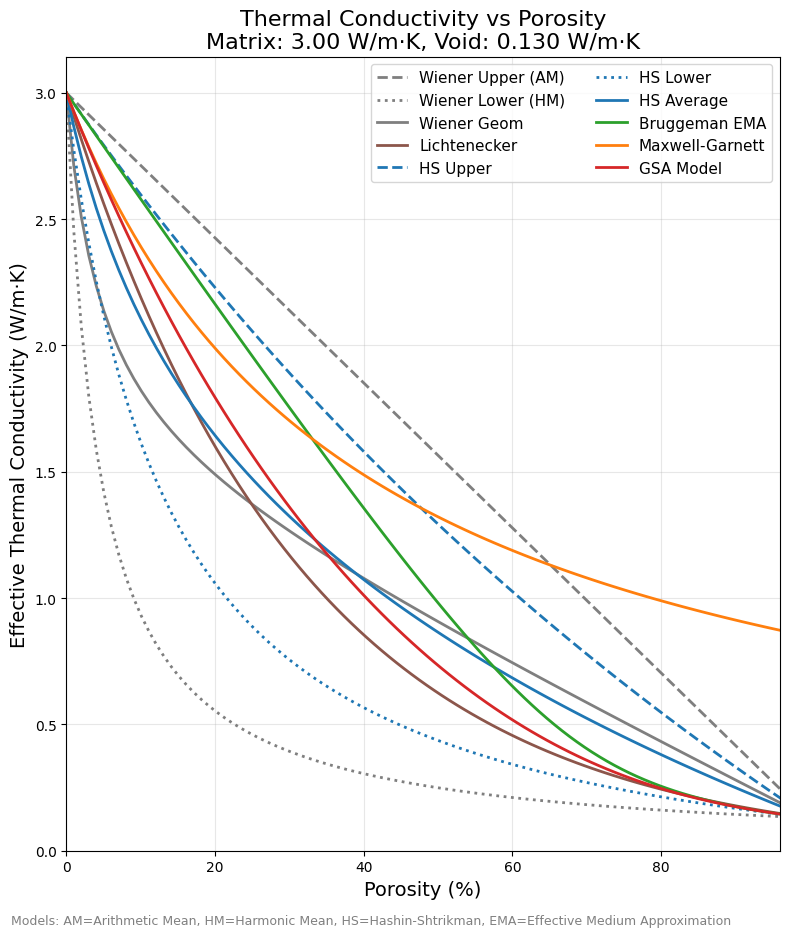

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional


# === CONFIGURATION ===
def run_porosity_vs_tc_plot():
    # Material properties
    lambda_matrix = 3    # W/m·K (e.g., polymer, concrete, ceramic)
    lambda_void = 0.13    # W/m·K (air at room temperature)

    porosity_values = np.linspace(0.0, 1.0, 100)  # φ_void

    # Prepare storage
    results = {
        'Wiener_Upper': [],
        'Wiener_Lower': [],
        'Wiener_Geom': [],
        'Lichtenecker': [],
        'HS_Lower': [],
        'HS_Upper': [],
        'HS_Average': [],
        'Bruggeman': [],
        'Maxwell': [],
        'GSA': []
    }

    # print("Computing effective thermal conductivity vs porosity...")
    # print(f"Matrix: {lambda_matrix:.3f} W/m·K, Void (air): {lambda_void:.3f} W/m·K\n")

    # Common alpha_i for Maxwell and GSA: spherical inclusions (AR = 1)
    alpha_i = [1.0, 0.1]  # [matrix, void] — though only void matters

    for i, phi_void in enumerate(porosity_values):
        phi_matrix = 1.0 - phi_void
        phi = [phi_matrix, phi_void]
        lam = [lambda_matrix, lambda_void]

        # Helper: safe model runner
        def safe_eval(func, *args, **kwargs):
            try:
                return float(func(*args, **kwargs))
            except Exception as e:
                print(f"  {func.__name__} failed: {e}")
                return np.nan

        # Wiener bounds
        wiener_lower, wiener_upper, wiener_avg = Wiener_Lower_Bound(phi, lam), Wiener_Upper_Bound(phi, lam), Wiener_Average(phi, lam)
        results['Wiener_Upper'].append(wiener_upper)
        results['Wiener_Lower'].append(wiener_lower)
        results['Wiener_Geom'].append(wiener_avg)

        # Lichtenecker
        results['Lichtenecker'].append(safe_eval(Lichtenecker, phi, lam, alpha_i))

        # Hashin-Shtrikman
        results['HS_Lower'].append(safe_eval(Lower_Hashin_Strikman, phi, lam, alpha_i))
        results['HS_Upper'].append(safe_eval(Upper_Hashin_Strikman, phi, lam, alpha_i))
        results['HS_Average'].append(safe_eval(Hashin_Strikman_Average, phi, lam, alpha_i))

        # Bruggeman EMA
        results['Bruggeman'].append(safe_eval(Bruggeman_EMA, phi, lam, alpha_i))

        # Maxwell (matrix = index 0)
        results['Maxwell'].append(safe_eval(Maxwell, phi, lam, alpha_i))

        # GSA model
        results['GSA'].append(safe_eval(GSA, phi, lam, alpha_i))

    # Convert to arrays
    for key in results:
        results[key] = np.array(results[key])

    # === PLOTTING ===
    plt.figure(figsize=(8, 10))
    porosity_plot = porosity_values * 100  # Convert to percent

    # Define plot styles
    styles = {
        'Wiener_Upper': ('tab:gray', '--', 'Wiener Upper (AM)'),
        'Wiener_Lower': ('tab:gray', ':', 'Wiener Lower (HM)'),
        'Wiener_Geom': ('tab:gray', '-', 'Wiener Geom'),
        'Lichtenecker': ('tab:brown', '-', 'Lichtenecker'),
        'HS_Upper': ('tab:blue', '--', 'HS Upper'),
        'HS_Lower': ('tab:blue', ':', 'HS Lower'),
        'HS_Average': ('tab:blue', '-', 'HS Average'),
        'Bruggeman': ('tab:green', '-', 'Bruggeman EMA'),
        'Maxwell': ('tab:orange', '-', 'Maxwell-Garnett'),
        'GSA': ('tab:red', '-', 'GSA Model'),
    }

    # print(" All models computed. Generating plot...")

    for key, (color, ls, label) in styles.items():
        data = results[key]
        valid = ~np.isnan(data)
        if np.any(valid):
            plt.plot(porosity_plot[valid], data[valid], color=color, linestyle=ls, linewidth=2, label=label)
        else:
            print(f"No valid data for {key}")

    # Formatting
    plt.xlabel('Porosity (%)', fontsize=14)
    plt.ylabel('Effective Thermal Conductivity (W/m·K)', fontsize=14)
    plt.title(f'Thermal Conductivity vs Porosity\n'
              f'Matrix: {lambda_matrix:.2f} W/m·K, Void: {lambda_void:.3f} W/m·K', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11, loc='upper right', ncol=2)
    plt.xlim(0, 96)
    plt.ylim(bottom=0)

    # Add text about models
    plt.figtext(0.02, 0.02,
                "Models: AM=Arithmetic Mean, HM=Harmonic Mean, "
                "HS=Hashin-Shtrikman, EMA=Effective Medium Approximation",
                fontsize=9, color='gray')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# === RUN IT ===
if __name__ == "__main__":
    run_porosity_vs_tc_plot()